 # RECONOCIMIENTO DE ESPECIES DE CANGREJOS A PARTIR DE SEÑALES ACÚSTICAS 

 En este trabajo se desarrolla un clasificador acústico pensado para su futura implementación en un sistema portátil destinado a la detección, adquisición y clasificación de señales generadas por Neohelice Granulata y Cyrtograpsus Angulatus. El objetivo final es contar con una solución autónoma capaz de operar en campo, identificar en tiempo real la presencia de cangrejos, determinar su especie y almacenar únicamente los segmentos de audio relevantes, optimizando así el uso de memoria y reduciendo datos irrelevantes. Para entrenar el clasificador, se recopilaron señales mediante hidrófonos en un entorno controlado, donde los eventos de interés presentaban baja relación señal-ruido y ocurrencia esporádica. Se aplicó un algoritmo de preprocesamiento basado en umbrales adaptativos sobre la envolvente acústica, diseñado para detectar automáticamente dichos eventos. Los fragmentos extraídos se utilizaron para entrenar una red neuronal profunda, la cual fue posteriormente cuantizada, optimizada y preparada para su implementación en un microcontrolador ESP32.

 ![Esquema del SISTEMA COMPLETO](flujo_trabajo_FINAL.png)


## DATOS
Los datos corresponden a audios de sonidos de cangrejos. Los datos son audios largos que contienen sonidos de cangrejos y sonidos ambientales. Dado que fueron grabados en un entorno controlado, se sabe que audio corresponde a vcda tipo de cangrejo. Antes de poder utilizar estos datos para entrenar la red es necesario aplicar algún algoritmo que permita separa el ruido ambiental del sonido del cangrejo. se espera que luego de entrenada la red pueda diferenciar entre dos tipo de cangrejos y separe del ruiod ambiental.

### CARPETAS DATOS

In [32]:
# Carpetas con etiquetas
import os
carpeta = {
    os.path.join("Neo"): 2,
    os.path.join("Cry"): 1,
    os.path.join("Ruido"): 0
}

### ENFOQUE EN ENERGIA +

Extraer características con Catch22 de segmentos más pequeños
Una vez que tenemos segmentos más pequeños de energía, podemos extraer características utilizando Catch22. Como las ventanas son ahora más pequeñas (adaptadas a la duración de la actividad), tenemos una mejor probabilidad de capturar solo las regiones activas.

In [33]:
import os
import numpy as np
from scipy.io import wavfile
from pycatch22 import catch22_all
import random

# PROCESO DE SUBMUESTREO DE LOS DATOS
# --- Parámetros --- #
downsample_factor = 64 # Submuestreo: tomar 1 de cada 32 muestras
tam_ventana = 2048    # Tamaño de ventana tras submuestreo

 # downsample_factor = 32  # Submuestreo
#Calculamos el tamaño real de la ventana en muestras
 # tam_ventana = random.randint(2048, 4096)

# --- Cargar datos y procesar --- #
carpetas = {
    "Neo": 2,
    "Cry": 1,
    "Ruido": 0
}

fragmentos_por_clase = {0: [], 1: [], 2: []}

# --- Funciones a aplicar ------------------------------------------------------ #
def downsample(signal, factor):
    return signal[factor // 2::factor]

def downsample_submuestreo_tipico(signal, factor):
    return signal[factor // 2::factor]

def downsample_rms(signal, factor):
    blocks = signal[:len(signal) - len(signal) % factor].reshape(-1, factor)
    return np.sqrt(np.mean(blocks**2, axis=1))

def downsample_random(signal, factor):
    blocks = signal[:len(signal) - len(signal) % factor].reshape(-1, factor)
    idxs = np.random.randint(0, factor, size=blocks.shape[0])
    return np.array([block[i] for block, i in zip(blocks, idxs)])

def downsample_median(signal, factor):
    return np.median(signal[:len(signal) - len(signal) % factor].reshape(-1, factor), axis=1)

def submuestrear(signal, factor):
    # Cortar para que sea múltiplo exacto del factor
    tam = len(signal) - (len(signal) % factor)
    signal = signal[:tam]
    # Promedio de cada bloque
    return signal.reshape(-1, factor).mean(axis=1)

def segmentar(signal, tam_ventana):
    cantidad = len(signal) // tam_ventana
    return [signal[i*tam_ventana:(i+1)*tam_ventana] for i in range(cantidad)]

# Función para calcular la FFT real
def downsample_fft(signal, factor):
    # Submuestrear la señal (esto es opcional dependiendo de si deseas hacerlo antes de la FFT)
    signal = signal[::factor]  # Esto toma 1 de cada "factor" muestras de la señal original.
    
    # 1. Calcular la FFT real
    fft_result = np.fft.rfft(signal)  # FFT real (parte positiva de la transformada)
    
    # 2. Devolver solo la magnitud
    fft_magnitude = np.abs(fft_result)
    return fft_magnitude

def downsample_log(signal, factor):
    # Primero submuestreamos como en los otros casos
    signal = signal[::factor]

    # Aplicamos el logaritmo
    # Le sumamos un pequeño valor epsilon para evitar log(0)
    epsilon = 1e-10
    signal_log = np.log(np.abs(signal) + epsilon)

    return signal_log

def extraer_features_de_segmentos(segmentos):
    features = []
    for fragmento in segmentos:
        caracteristicas = catch22_all(fragmento)
        features.append(caracteristicas)
    return features

# --- Procesar los audios --- #
for carpeta, etiqueta in carpetas.items():
    for archivo in os.listdir(carpeta):
        if archivo.endswith(".wav"):
            ruta = os.path.join(carpeta, archivo)
            sr, data = wavfile.read(ruta)

            if data.ndim > 1:
                data = data[:, 0]
            data = data.astype(np.float32)
            data /= np.max(np.abs(data))  # Normalización

            # Submuestreo con calculo de promedio
            #data_down = submuestrear(data, downsample_factor)

            # Submuestreo con caluclo de RMS
            data_down = downsample_rms(data, downsample_factor)

            # Submuestreo con caluclo mediana
            #data_down = downsample_median(data, downsample_factor)

            # Submuestreo tipico
            #data_down = downsample(data, downsample_factor)

            # Submuestreo Random
            #data_down = downsample_random(data, downsample_factor)

            # Submuestreo con FFT
            #data_down = downsample_fft(data, downsample_factor)
            
            # Submuestreo logaritmico
            #data_down = downsample_log(data, downsample_factor)

            # Segmentación en ventanas de 1024 muestras
            segmentos = segmentar(data_down, tam_ventana)

            # Extraer características con catch22
            features = extraer_features_de_segmentos(segmentos)

            fragmentos_por_clase[etiqueta].extend(features)

# --- Balancear dataset --- #
min_cantidad = min(len(f) for f in fragmentos_por_clase.values())
print(f"Usando {min_cantidad} fragmentos por clase.")

X = []
y = []

for clase, fragmentos in fragmentos_por_clase.items():
    seleccionados = random.sample(fragmentos, min_cantidad)
    X.extend(seleccionados)
    y.extend([clase] * min_cantidad)

X = np.array(X)
y = np.array(y)

print("Tamaño final balanceado:", X.shape, y.shape)


Usando 110 fragmentos por clase.
Tamaño final balanceado: (330,) (330,)


### DATOS DE TRAIN Y TEST 
- SEPARACIÓN DE SUBCONJUNTOS
- NORMALIZACIÓN ENTRE [0 Y 1]
- CONVERTIR DATOS DE ENTRADA A 8 BIT. 

#### SEPARACIÓN DE DATASET

In [34]:
from sklearn.model_selection import train_test_split

# Extraer solo los valores de cada diccionario
X_values = [item['values'] for item in X]

# Convertir a un array de NumPy
X_values = np.array(X_values)

# Ahora puedes proceder con la división y el entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_values, y, test_size=0.2, random_state=42)
print(y_test)


[0 1 1 0 0 0 0 2 2 1 1 2 0 0 2 1 1 2 0 1 0 0 1 2 0 1 2 2 2 2 2 2 1 2 2 2 1
 0 0 0 1 2 1 1 2 0 2 2 1 1 0 0 0 1 0 0 1 2 2 1 0 1 1 2 0 2]


In [35]:
print(X_values)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

[[ 0.62425688  0.80660494  7.75894489 ...  0.26530612  0.13499031
   0.42141775]
 [ 0.68888705  0.87899889  7.78359226 ...  0.26530612  0.13499031
   0.42235619]
 [ 0.74828875  0.556168    7.76560053 ...  0.28571429  0.13499031
   0.41857949]
 ...
 [-0.86318868 -1.10533213 16.35079307 ...  0.3877551   0.05522331
   0.28257952]
 [-0.80323631 -1.05815934  9.24784639 ...  0.14285714  0.04908739
   0.49849583]
 [-0.2869794   0.41255172 10.11618189 ...  0.40816327  0.13192235
   0.37777496]]
(264, 22)
(66, 22)
(264,)
(66,)


#### NORMALIZADO

In [36]:
# NORMALIZADO
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()  # OBSERVAR QUE EL NORMALIZADO ES ENTRE 0 Y 1
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### CUANTIZADO

In [37]:
# Cuantizar a 8 bits
def quantize_to_8bits(x):
    x_quantized = np.round(x * 255) / 255
    return x_quantized

X_train = quantize_to_8bits(X_train)
X_test = quantize_to_8bits(X_test)


In [38]:
print(X_test)

[[0.83921569 0.93333333 0.05882353 ... 0.21568627 0.18431373 0.35294118]
 [0.60392157 0.49803922 0.44705882 ... 0.         0.01960784 0.10588235]
 [0.48627451 0.38823529 0.58823529 ... 0.         0.01960784 0.28627451]
 ...
 [0.12941176 0.10196078 0.1372549  ... 0.3254902  0.08235294 0.16470588]
 [0.83921569 0.01568627 0.05882353 ... 0.18823529 0.18431373 0.35686275]
 [0.66666667 0.58039216 0.12156863 ... 0.24313725 0.09019608 0.19215686]]


## MODELOS DE REDES - ALUMNO Y MAESTRO
Se construirán dos modelos de red de clasificación. Una red extremadamente simple y cuantizada que se denominará ESTUDIANTE y un modelo de red densamente conectada no cuantizada que se denomirá MAESTRO.

In [39]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

### MODELO DE RED ALUMNO - RED CUANTIZADA
 El modelo estudiante o alumno es el que se va a implementar. A modo de simular mejor los efectos de la cuantización de l implementación real, se utiliza un modelo de red cuantizada que simula los efectos de la cuantización. 

#### LIBRERÍAS

In [40]:
from qkeras import *
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm
import matplotlib.pyplot as plt

#### ARQUITECTURA DEL ALUMNO

In [42]:
kernelQ = "quantized_bits(8,2,alpha=1)"
biasQ = "quantized_bits(8, 2,alpha=1)"
activationQ = 'quantized_bits(8, 2)'

def build_student():
    model = Sequential([
            Input(shape=(22,)),  # <- Agregamos la capa de entrada correctamente
            QActivation(activation=quantized_bits(8, 0,False)),  # <- Agregamos esta capa para que emule la entrada cuantizada a 8 bits
            QDense(32,name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
            QActivation(activation= activationQ ,  name='relu1'),

            QDense(16, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
            QActivation(activation=activationQ, name='relu2'),                              

            QDense(8, name='fc3',
                       kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                      kernel_initializer='lecun_uniform'),
            QActivation(activation=activationQ, name='relu3'), 
                
           QDense(3, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
        
    ])
    return model

In [43]:
student = build_student()
student.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_activation_2 (QActivation  (None, 22)               0         
 )                                                               
                                                                 
 fc1 (QDense)                (None, 32)                736       
                                                                 
 relu1 (QActivation)         (None, 32)                0         
                                                                 
 fc2 (QDense)                (None, 16)                528       
                                                                 
 relu2 (QActivation)         (None, 16)                0         
                                                                 
 fc3 (QDense)                (None, 8)                 136       
                                                      

### MODELO DE MAESTRO 
Se define un modelo de red neuronal densa y se entrena. Esta red servirá para el proceso de destilación del conocimiento.

#### ARQUITECTURA

In [44]:
# Definir el modelo Teacher con convolucionales 1D
#Cada entrada es una serie de 512 muestras → input shape: (512, 1)
#Las salidas son tres parámetros continuos → output shape: (3,)
#Usamos convolucionales 1D en lugar de MLP.

def build_teacher():
    model = Sequential([    
    #InputLayer(input_shape=(22, 1)),  # 512 muestras por serie, 1 canal
      #  Conv1D(128, kernel_size=5, activation='relu', padding='same'),
      #  MaxPooling1D(pool_size=2),  # Reduce a 500 pasos

      #  Conv1D(64, kernel_size=5, activation='relu', padding='same'),
      #  MaxPooling1D(pool_size=2),  # Reduce a 250 pasos

      #  Conv1D(32, kernel_size=4, activation='relu', padding='same'),
      #  MaxPooling1D(pool_size=2),  # Reduce a 250 pasos

    #Flatten(),
    # Capa de entrada: 22 características (X.shape[1] = 22)
    Dense(128, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(X_train.shape[1],)),  # 64 neuronas, activación ReLU
    Dropout(0.3),
    Dense(96, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # 64 neuronas, activación ReLU
    Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # 64 neuronas, activación ReLU
    Dense(48, activation='relu'),  # 64 neuronas, activación ReLU
    Dense(32, activation='relu'),  # Capa oculta con 32 neuronas    
    Dense(16, activation='relu'),  # Capa oculta con 32 neuronas
    #BatchNormalization(),
    Dense(8, activation='relu'),  # Capa oculta con 32 neuronas
    BatchNormalization(),
    Dense(3, activation='softmax')  # Capa de salida con 2 neuronas (para clasificación binaria)
])
    return model

#### ENTRENAMIENTO

In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Crear y compilar el modelo
teacher = build_teacher()
teacher.summary()

# Entrenamiento del modelo
# Define la función que ajustará el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 10:
        return lr  # El learning rate no cambia en las primeras 10 épocas
    else:
        return lr * 0.9  # Reduce el learning rate en un 10% después de la época 10
#-------------------------------------------------------------------------------
# Crear el optimizador sin un learning rate fijo
optimizer = Adam()

#-------------------------------------------------------------------------------
# Compilar el modelo (sin especificar el learning rate aquí)
###COMPILAR EL MODELO TEACHER

teacher.compile(optimizer=optimizer, # El optimizador sin el learning rate
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy']) 

#-------------------------------------------------------------------------------
# Crear el callback del LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

### ENTRENAR EL MODELO TEACHER
history_teacher = teacher.fit(X_train, y_train,
                     validation_data=(X_test, y_test),
                     epochs=200,
                     batch_size=50,
                     callbacks=[lr_scheduler, early_stop])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               2944      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 96)                12384     
                                                                 
 dense_18 (Dense)            (None, 64)                6208      
                                                                 
 dense_19 (Dense)            (None, 48)                3120      
                                                                 
 dense_20 (Dense)            (None, 32)                1568      
                                                                 
 dense_21 (Dense)            (None, 16)               

## DESTILACIÓN DEL CONOCIMIENTO
Entrenamiento por destilación del conocimiento:
Este enfoque consiste en entrenar un modelo pequeño (estudiante) para que aprenda a imitar el comportamiento de un modelo más grande y preciso (maestro). En lugar de entrenar al estudiante directamente con las etiquetas verdaderas, se utilizan las salidas del maestro (probabilidades suavizadas) como objetivo. Esto permite transferir el "conocimiento" del maestro al estudiante, mejorando su desempeño incluso con menor capacidad y precisión (por ejemplo, en redes cuantizadas).

![Esquema del proceso de Destilación](destilacion.png)


### ENTRENAMIENTO DEL ALUMNO

In [46]:
from distillationClassKeras import *
distilledMLP = Distiller(student=student, teacher=teacher)
distilledMLP.student.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_activation_2 (QActivation  (None, 22)               0         
 )                                                               
                                                                 
 fc1 (QDense)                (None, 32)                736       
                                                                 
 relu1 (QActivation)         (None, 32)                0         
                                                                 
 fc2 (QDense)                (None, 16)                528       
                                                                 
 relu2 (QActivation)         (None, 16)                0         
                                                                 
 fc3 (QDense)                (None, 8)                 136       
                                                      

In [47]:
# Proceso de destilación del conocimiento
# Entrenamiento del modelo
distilledMLP.compile(
        optimizer='adam',
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.65, 
        temperature=10,
    )

early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

### ENTRENAR EL MODELO destilado
history_distilledMLP = distilledMLP.fit(X_train, y_train,
                     validation_data=(X_test, y_test),
                     epochs=300,
                     batch_size=50,
                     callbacks=[lr_scheduler, early_stop])



Epoch 1/300


c:\Users\CELESTE\anaconda3\envs\tinyml\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/6 [====>.........................] - ETA: 4s - sparse_categorical_accuracy: 0.3600 - student_loss: 1.0638 - distillation_loss: 8.1221e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 1s 57ms/step - sparse_categorical_accuracy: 0.3939 - student_loss: 1.0454 - distillation_loss: 7.5972e-04 - val_sparse_categorical_accuracy: 0.4545 - val_student_loss: 1.0357 - lr: 0.0010
Epoch 2/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.5000 - student_loss: 1.0353 - distillation_loss: 7.1742e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.6023 - student_loss: 1.0197 - distillation_loss: 7.3928e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 1.0024 - lr: 0.0010
Epoch 3/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.7600 - student_loss: 0.9791 - distillation_loss: 7.1268e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.7538 - student_loss: 0.9645 - distillation_loss: 6.8253e-04 - val_sparse_categorical_accuracy: 0.7424 - val_student_loss: 0.9653 - lr: 0.0010
Epoch 4/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.7400 - student_loss: 0.9572 - distillation_loss: 6.3391e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.7386 - student_loss: 0.9431 - distillation_loss: 6.5808e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.9307 - lr: 0.0010
Epoch 5/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.7800 - student_loss: 0.9157 - distillation_loss: 6.1953e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.7841 - student_loss: 0.9012 - distillation_loss: 6.0226e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.9040 - lr: 0.0010
Epoch 6/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.6200 - student_loss: 0.9511 - distillation_loss: 6.2385e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.7992 - student_loss: 0.8668 - distillation_loss: 5.7896e-04 - val_sparse_categorical_accuracy: 0.7576 - val_student_loss: 0.8653 - lr: 0.0010
Epoch 7/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.8540 - distillation_loss: 5.7079e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.7955 - student_loss: 0.8478 - distillation_loss: 5.4825e-04 - val_sparse_categorical_accuracy: 0.7576 - val_student_loss: 0.8270 - lr: 0.0010
Epoch 8/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.8242 - distillation_loss: 5.3023e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.7992 - student_loss: 0.7628 - distillation_loss: 4.5923e-04 - val_sparse_categorical_accuracy: 0.7727 - val_student_loss: 0.7855 - lr: 0.0010
Epoch 9/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.7397 - distillation_loss: 4.7487e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8106 - student_loss: 0.7319 - distillation_loss: 4.4271e-04 - val_sparse_categorical_accuracy: 0.7424 - val_student_loss: 0.7480 - lr: 0.0010
Epoch 10/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.7400 - student_loss: 0.7610 - distillation_loss: 4.3109e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 10ms/step - sparse_categorical_accuracy: 0.8182 - student_loss: 0.6993 - distillation_loss: 3.8317e-04 - val_sparse_categorical_accuracy: 0.7879 - val_student_loss: 0.6949 - lr: 0.0010
Epoch 11/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.6519 - distillation_loss: 3.2609e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8371 - student_loss: 0.6717 - distillation_loss: 3.5984e-04 - val_sparse_categorical_accuracy: 0.7727 - val_student_loss: 0.6622 - lr: 9.0000e-04
Epoch 12/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.6014 - distillation_loss: 3.3877e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.8409 - student_loss: 0.6441 - distillation_loss: 3.2637e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.6309 - lr: 8.1000e-04
Epoch 13/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.5478 - distillation_loss: 2.7085e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8523 - student_loss: 0.5867 - distillation_loss: 2.7194e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.5970 - lr: 7.2900e-04
Epoch 14/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.5522 - distillation_loss: 2.6324e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 14ms/step - sparse_categorical_accuracy: 0.8561 - student_loss: 0.5740 - distillation_loss: 2.6400e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.5646 - lr: 6.5610e-04
Epoch 15/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4893 - distillation_loss: 2.1839e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8561 - student_loss: 0.5128 - distillation_loss: 2.5111e-04 - val_sparse_categorical_accuracy: 0.7879 - val_student_loss: 0.5528 - lr: 5.9049e-04
Epoch 16/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.4846 - distillation_loss: 2.1260e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8523 - student_loss: 0.5361 - distillation_loss: 2.3745e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.5338 - lr: 5.3144e-04
Epoch 17/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8000 - student_loss: 0.5137 - distillation_loss: 2.8084e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8561 - student_loss: 0.4573 - distillation_loss: 1.9230e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.5190 - lr: 4.7830e-04
Epoch 18/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4505 - distillation_loss: 2.1185e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8712 - student_loss: 0.4698 - distillation_loss: 2.2162e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.5008 - lr: 4.3047e-04
Epoch 19/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4187 - distillation_loss: 1.7351e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8788 - student_loss: 0.4506 - distillation_loss: 1.8062e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4885 - lr: 3.8742e-04
Epoch 20/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8000 - student_loss: 0.4792 - distillation_loss: 1.7880e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8750 - student_loss: 0.4193 - distillation_loss: 1.7783e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.4688 - lr: 3.4868e-04
Epoch 21/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.7800 - student_loss: 0.5079 - distillation_loss: 2.2562e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 10ms/step - sparse_categorical_accuracy: 0.8712 - student_loss: 0.5150 - distillation_loss: 1.9050e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.4669 - lr: 3.1381e-04
Epoch 22/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3445 - distillation_loss: 1.4836e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4061 - distillation_loss: 1.6235e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.4591 - lr: 2.8243e-04
Epoch 23/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8000 - student_loss: 0.4543 - distillation_loss: 1.9533e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4112 - distillation_loss: 1.5391e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4539 - lr: 2.5419e-04
Epoch 24/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4461 - distillation_loss: 1.4231e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8788 - student_loss: 0.4170 - distillation_loss: 1.4525e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4526 - lr: 2.2877e-04
Epoch 25/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4777 - distillation_loss: 1.9195e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3922 - distillation_loss: 1.4820e-04 - val_sparse_categorical_accuracy: 0.8030 - val_student_loss: 0.4507 - lr: 2.0589e-04
Epoch 26/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4257 - distillation_loss: 1.4517e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.5063 - distillation_loss: 1.6138e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4407 - lr: 1.8530e-04
Epoch 27/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4254 - distillation_loss: 1.6000e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8977 - student_loss: 0.4482 - distillation_loss: 1.4463e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4351 - lr: 1.6677e-04
Epoch 28/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4119 - distillation_loss: 2.0738e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3623 - distillation_loss: 1.3582e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4321 - lr: 1.5009e-04
Epoch 29/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4002 - distillation_loss: 1.4125e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8939 - student_loss: 0.3920 - distillation_loss: 1.3587e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4303 - lr: 1.3509e-04
Epoch 30/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4526 - distillation_loss: 1.8673e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8939 - student_loss: 0.4147 - distillation_loss: 1.5342e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4279 - lr: 1.2158e-04
Epoch 31/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3578 - distillation_loss: 9.3708e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3723 - distillation_loss: 1.3803e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4239 - lr: 1.0942e-04
Epoch 32/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4026 - distillation_loss: 1.3978e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3863 - distillation_loss: 1.5232e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4272 - lr: 9.8477e-05
Epoch 33/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3654 - distillation_loss: 9.0554e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 14ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3771 - distillation_loss: 1.3321e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4258 - lr: 8.8629e-05
Epoch 34/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4353 - distillation_loss: 1.4791e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3968 - distillation_loss: 1.4613e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4255 - lr: 7.9766e-05
Epoch 35/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3268 - distillation_loss: 1.1849e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3889 - distillation_loss: 1.3261e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4222 - lr: 7.1790e-05
Epoch 36/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3371 - distillation_loss: 1.1595e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3742 - distillation_loss: 1.3597e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4234 - lr: 6.4611e-05
Epoch 37/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3760 - distillation_loss: 1.1004e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3741 - distillation_loss: 1.1127e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4200 - lr: 5.8150e-05
Epoch 38/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.2808 - distillation_loss: 8.0570e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3823 - distillation_loss: 1.3587e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4203 - lr: 5.2335e-05
Epoch 39/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4326 - distillation_loss: 1.2693e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3492 - distillation_loss: 1.2622e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4191 - lr: 4.7101e-05
Epoch 40/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4024 - distillation_loss: 1.2137e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3363 - distillation_loss: 1.0812e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4160 - lr: 4.2391e-05
Epoch 41/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3913 - distillation_loss: 1.7114e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3775 - distillation_loss: 1.1158e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4156 - lr: 3.8152e-05
Epoch 42/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3680 - distillation_loss: 1.2224e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8977 - student_loss: 0.3893 - distillation_loss: 1.1250e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4111 - lr: 3.4337e-05
Epoch 43/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4292 - distillation_loss: 1.1513e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.9015 - student_loss: 0.3359 - distillation_loss: 1.1643e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4112 - lr: 3.0903e-05
Epoch 44/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3476 - distillation_loss: 1.2722e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8939 - student_loss: 0.4229 - distillation_loss: 1.3930e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4082 - lr: 2.7813e-05
Epoch 45/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4774 - distillation_loss: 1.3931e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8939 - student_loss: 0.3232 - distillation_loss: 1.0552e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4057 - lr: 2.5032e-05
Epoch 46/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3465 - distillation_loss: 1.1322e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8939 - student_loss: 0.3509 - distillation_loss: 1.1744e-04 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 0.4057 - lr: 2.2528e-05
Epoch 47/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4185 - distillation_loss: 1.3002e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8939 - student_loss: 0.3395 - distillation_loss: 1.1676e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4073 - lr: 2.0276e-05
Epoch 48/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3096 - distillation_loss: 1.2407e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3685 - distillation_loss: 1.1434e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4090 - lr: 1.8248e-05
Epoch 49/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3920 - distillation_loss: 9.7021e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3665 - distillation_loss: 1.1393e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4082 - lr: 1.6423e-05
Epoch 50/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3888 - distillation_loss: 1.2997e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3405 - distillation_loss: 1.1471e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4073 - lr: 1.4781e-05
Epoch 51/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.3987 - distillation_loss: 1.1059e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 13ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3919 - distillation_loss: 1.0651e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4058 - lr: 1.3303e-05
Epoch 52/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4228 - distillation_loss: 1.2450e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3837 - distillation_loss: 1.2161e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4057 - lr: 1.1973e-05
Epoch 53/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4693 - distillation_loss: 1.0799e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3672 - distillation_loss: 1.3957e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4057 - lr: 1.0775e-05
Epoch 54/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3647 - distillation_loss: 1.0068e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3453 - distillation_loss: 1.1287e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4057 - lr: 9.6977e-06
Epoch 55/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.3162 - distillation_loss: 1.1594e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3654 - distillation_loss: 1.2224e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4056 - lr: 8.7280e-06
Epoch 56/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3024 - distillation_loss: 1.0570e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3501 - distillation_loss: 1.0957e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4065 - lr: 7.8552e-06
Epoch 57/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.2796 - distillation_loss: 1.0426e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3426 - distillation_loss: 1.1792e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4071 - lr: 7.0697e-06
Epoch 58/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3348 - distillation_loss: 1.1210e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3749 - distillation_loss: 1.3801e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4071 - lr: 6.3627e-06
Epoch 59/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3734 - distillation_loss: 1.4132e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4092 - distillation_loss: 1.2955e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4071 - lr: 5.7264e-06
Epoch 60/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4462 - distillation_loss: 1.5283e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3552 - distillation_loss: 1.1644e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4071 - lr: 5.1538e-06
Epoch 61/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3905 - distillation_loss: 1.2699e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3481 - distillation_loss: 1.3656e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4071 - lr: 4.6384e-06
Epoch 62/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3772 - distillation_loss: 1.3419e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3333 - distillation_loss: 1.1384e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4071 - lr: 4.1746e-06
Epoch 63/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4242 - distillation_loss: 1.5552e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3474 - distillation_loss: 1.2453e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4071 - lr: 3.7571e-06
Epoch 64/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3766 - distillation_loss: 1.0648e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3762 - distillation_loss: 1.4656e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4071 - lr: 3.3814e-06
Epoch 65/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4199 - distillation_loss: 1.3177e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3907 - distillation_loss: 1.1246e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4077 - lr: 3.0433e-06
Epoch 66/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3533 - distillation_loss: 1.4767e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3385 - distillation_loss: 1.1467e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4068 - lr: 2.7389e-06
Epoch 67/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.2715 - distillation_loss: 9.2690e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3995 - distillation_loss: 1.1486e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4068 - lr: 2.4650e-06
Epoch 68/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3635 - distillation_loss: 7.5898e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.4041 - distillation_loss: 1.2418e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4068 - lr: 2.2185e-06
Epoch 69/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3904 - distillation_loss: 1.0836e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3450 - distillation_loss: 1.0579e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4068 - lr: 1.9967e-06
Epoch 70/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4073 - distillation_loss: 1.1504e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8902 - student_loss: 0.3882 - distillation_loss: 1.1981e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4066 - lr: 1.7970e-06
Epoch 71/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3685 - distillation_loss: 1.3115e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3512 - distillation_loss: 1.3208e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.6173e-06
Epoch 72/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4146 - distillation_loss: 9.9541e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4277 - distillation_loss: 1.2893e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.4556e-06
Epoch 73/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3555 - distillation_loss: 1.1110e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3623 - distillation_loss: 1.2624e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.3100e-06
Epoch 74/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4149 - distillation_loss: 9.2057e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3231 - distillation_loss: 1.1196e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1790e-06
Epoch 75/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3088 - distillation_loss: 1.0990e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3474 - distillation_loss: 1.2212e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0611e-06
Epoch 76/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3901 - distillation_loss: 1.2104e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3266 - distillation_loss: 1.0616e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.5501e-07
Epoch 77/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4472 - distillation_loss: 1.5683e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3421 - distillation_loss: 1.1234e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.5950e-07
Epoch 78/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3334 - distillation_loss: 1.0109e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3374 - distillation_loss: 1.1373e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.7355e-07
Epoch 79/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3820 - distillation_loss: 1.3714e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3825 - distillation_loss: 1.1464e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.9620e-07
Epoch 80/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.4046 - distillation_loss: 1.3647e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3569 - distillation_loss: 1.3344e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.2658e-07
Epoch 81/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3987 - distillation_loss: 1.5469e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 13ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3615 - distillation_loss: 1.2047e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.6392e-07
Epoch 82/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9800 - student_loss: 0.2412 - distillation_loss: 9.2836e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3719 - distillation_loss: 1.2058e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.0753e-07
Epoch 83/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3827 - distillation_loss: 1.0273e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3907 - distillation_loss: 1.3454e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.5678e-07
Epoch 84/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3385 - distillation_loss: 8.8044e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3582 - distillation_loss: 1.1885e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.1110e-07
Epoch 85/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3903 - distillation_loss: 1.0839e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3753 - distillation_loss: 1.1664e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.6999e-07
Epoch 86/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4004 - distillation_loss: 1.0828e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4026 - distillation_loss: 1.4036e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.3299e-07
Epoch 87/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3503 - distillation_loss: 1.3689e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3394 - distillation_loss: 1.0824e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.9969e-07
Epoch 88/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8000 - student_loss: 0.4486 - distillation_loss: 1.4323e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3418 - distillation_loss: 1.1667e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.6972e-07
Epoch 89/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3985 - distillation_loss: 1.4653e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3629 - distillation_loss: 1.2353e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.4275e-07
Epoch 90/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3473 - distillation_loss: 6.8716e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3376 - distillation_loss: 1.1620e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.1847e-07
Epoch 91/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4214 - distillation_loss: 1.5046e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3507 - distillation_loss: 1.1516e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.9663e-07
Epoch 92/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4149 - distillation_loss: 1.4948e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4315 - distillation_loss: 1.4240e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.7696e-07
Epoch 93/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.3525 - distillation_loss: 9.8584e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3471 - distillation_loss: 1.2008e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.5927e-07
Epoch 94/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3293 - distillation_loss: 9.2282e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3274 - distillation_loss: 1.0485e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.4334e-07
Epoch 95/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3913 - distillation_loss: 1.6064e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3282 - distillation_loss: 1.0260e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.2901e-07
Epoch 96/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3388 - distillation_loss: 1.2130e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3869 - distillation_loss: 1.3492e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1611e-07
Epoch 97/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3639 - distillation_loss: 1.2455e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3478 - distillation_loss: 1.1970e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0450e-07
Epoch 98/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3856 - distillation_loss: 1.3820e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4074 - distillation_loss: 1.2442e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.4046e-08
Epoch 99/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4207 - distillation_loss: 1.4187e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3660 - distillation_loss: 1.0474e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.4642e-08
Epoch 100/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4051 - distillation_loss: 1.2182e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3459 - distillation_loss: 1.1651e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.6177e-08
Epoch 101/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4513 - distillation_loss: 1.4691e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3550 - distillation_loss: 1.1122e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.8560e-08
Epoch 102/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3221 - distillation_loss: 9.2268e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3577 - distillation_loss: 1.1836e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.1704e-08
Epoch 103/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3530 - distillation_loss: 7.3946e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3717 - distillation_loss: 1.4957e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.5533e-08
Epoch 104/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4451 - distillation_loss: 1.7312e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4055 - distillation_loss: 1.1326e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.9980e-08
Epoch 105/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3430 - distillation_loss: 1.5542e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3491 - distillation_loss: 1.0398e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.4982e-08
Epoch 106/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3370 - distillation_loss: 1.1793e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4219 - distillation_loss: 1.2702e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.0484e-08
Epoch 107/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3950 - distillation_loss: 9.8217e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3717 - distillation_loss: 1.0646e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.6435e-08
Epoch 108/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3455 - distillation_loss: 1.1060e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3385 - distillation_loss: 1.1689e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.2792e-08
Epoch 109/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3559 - distillation_loss: 9.6580e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3441 - distillation_loss: 1.2806e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.9513e-08
Epoch 110/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3001 - distillation_loss: 1.0370e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3530 - distillation_loss: 1.2588e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.6561e-08
Epoch 111/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3063 - distillation_loss: 8.8225e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3274 - distillation_loss: 1.0156e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.3905e-08
Epoch 112/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3394 - distillation_loss: 1.1318e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4087 - distillation_loss: 1.2445e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.1515e-08
Epoch 113/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3515 - distillation_loss: 1.0957e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3791 - distillation_loss: 1.2522e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.9363e-08
Epoch 114/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.2857 - distillation_loss: 1.1927e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3661 - distillation_loss: 1.1032e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.7427e-08
Epoch 115/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.3160 - distillation_loss: 1.5363e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3223 - distillation_loss: 1.0126e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.5684e-08
Epoch 116/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8000 - student_loss: 0.5087 - distillation_loss: 1.5452e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 13ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3665 - distillation_loss: 1.1207e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.4116e-08
Epoch 117/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.2933 - distillation_loss: 1.1783e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4249 - distillation_loss: 1.1614e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.2704e-08
Epoch 118/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3093 - distillation_loss: 7.6622e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3535 - distillation_loss: 1.1250e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1434e-08
Epoch 119/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.2865 - distillation_loss: 1.0736e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3732 - distillation_loss: 1.2541e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0290e-08
Epoch 120/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3512 - distillation_loss: 1.1078e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3587 - distillation_loss: 1.2140e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.2614e-09
Epoch 121/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3038 - distillation_loss: 9.3371e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3307 - distillation_loss: 1.0288e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.3353e-09
Epoch 122/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4550 - distillation_loss: 1.5666e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3594 - distillation_loss: 1.2029e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.5017e-09
Epoch 123/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4083 - distillation_loss: 1.4043e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3584 - distillation_loss: 1.4158e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.7516e-09
Epoch 124/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4685 - distillation_loss: 1.2841e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3407 - distillation_loss: 1.0389e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.0764e-09
Epoch 125/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4190 - distillation_loss: 1.3675e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3987 - distillation_loss: 1.0945e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.4688e-09
Epoch 126/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3384 - distillation_loss: 1.0783e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3541 - distillation_loss: 1.1243e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.9219e-09
Epoch 127/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3793 - distillation_loss: 9.8843e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3823 - distillation_loss: 1.3003e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.4297e-09
Epoch 128/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4407 - distillation_loss: 1.0754e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3405 - distillation_loss: 1.1403e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.9867e-09
Epoch 129/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3611 - distillation_loss: 1.4534e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3593 - distillation_loss: 1.2906e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.5881e-09
Epoch 130/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4021 - distillation_loss: 1.7715e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4048 - distillation_loss: 1.1338e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.2292e-09
Epoch 131/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3504 - distillation_loss: 1.3358e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3421 - distillation_loss: 1.1338e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.9063e-09
Epoch 132/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3287 - distillation_loss: 1.0174e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3651 - distillation_loss: 1.3614e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.6157e-09
Epoch 133/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3923 - distillation_loss: 8.9342e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 13ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3394 - distillation_loss: 1.0851e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.3541e-09
Epoch 134/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3903 - distillation_loss: 1.3634e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3967 - distillation_loss: 1.1986e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.1187e-09
Epoch 135/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3232 - distillation_loss: 1.0901e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3879 - distillation_loss: 9.9224e-05 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.9068e-09
Epoch 136/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4174 - distillation_loss: 1.3148e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3977 - distillation_loss: 1.1851e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.7162e-09
Epoch 137/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3548 - distillation_loss: 1.4177e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3169 - distillation_loss: 1.0122e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.5445e-09
Epoch 138/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4219 - distillation_loss: 1.4582e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3390 - distillation_loss: 1.1059e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.3901e-09
Epoch 139/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3280 - distillation_loss: 1.1273e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3418 - distillation_loss: 1.1480e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.2511e-09
Epoch 140/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3877 - distillation_loss: 1.3425e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4002 - distillation_loss: 1.2691e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1260e-09
Epoch 141/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3486 - distillation_loss: 7.9243e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4496 - distillation_loss: 1.3549e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0134e-09
Epoch 142/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.7600 - student_loss: 0.4835 - distillation_loss: 1.4403e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4126 - distillation_loss: 1.4360e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.1203e-10
Epoch 143/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3830 - distillation_loss: 1.4532e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3702 - distillation_loss: 1.1887e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.2083e-10
Epoch 144/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8000 - student_loss: 0.4984 - distillation_loss: 1.9119e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3556 - distillation_loss: 1.1543e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.3875e-10
Epoch 145/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4274 - distillation_loss: 1.2946e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3843 - distillation_loss: 1.1699e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.6487e-10
Epoch 146/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3098 - distillation_loss: 1.1345e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3548 - distillation_loss: 1.2106e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.9839e-10
Epoch 147/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4319 - distillation_loss: 1.3727e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3297 - distillation_loss: 1.0406e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.3855e-10
Epoch 148/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3521 - distillation_loss: 1.3198e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3628 - distillation_loss: 1.3598e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.8469e-10
Epoch 149/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3661 - distillation_loss: 1.0491e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3698 - distillation_loss: 1.2563e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.3622e-10
Epoch 150/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3291 - distillation_loss: 1.1294e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4240 - distillation_loss: 1.4395e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.9260e-10
Epoch 151/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3707 - distillation_loss: 1.6362e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4471 - distillation_loss: 1.2696e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.5334e-10
Epoch 152/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3789 - distillation_loss: 1.2886e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3567 - distillation_loss: 1.0644e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.1801e-10
Epoch 153/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4103 - distillation_loss: 1.5423e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3804 - distillation_loss: 1.2960e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.8621e-10
Epoch 154/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3743 - distillation_loss: 1.4305e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3384 - distillation_loss: 1.0041e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.5759e-10
Epoch 155/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3224 - distillation_loss: 1.0553e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3301 - distillation_loss: 1.1144e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.3183e-10
Epoch 156/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3666 - distillation_loss: 9.6093e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3248 - distillation_loss: 1.0881e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.0864e-10
Epoch 157/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3438 - distillation_loss: 9.3937e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3480 - distillation_loss: 1.2533e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.8778e-10
Epoch 158/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4588 - distillation_loss: 1.3538e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3414 - distillation_loss: 1.1785e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.6900e-10
Epoch 159/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3982 - distillation_loss: 9.1956e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3739 - distillation_loss: 1.4114e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.5210e-10
Epoch 160/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4159 - distillation_loss: 1.4868e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3326 - distillation_loss: 1.1141e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.3689e-10
Epoch 161/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3296 - distillation_loss: 9.1736e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3576 - distillation_loss: 1.1425e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.2320e-10
Epoch 162/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3911 - distillation_loss: 1.4359e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3238 - distillation_loss: 1.0348e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1088e-10
Epoch 163/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3783 - distillation_loss: 1.4620e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3398 - distillation_loss: 1.0387e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.9794e-11
Epoch 164/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4105 - distillation_loss: 1.6764e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3393 - distillation_loss: 1.0962e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.9815e-11
Epoch 165/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4510 - distillation_loss: 1.1902e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4172 - distillation_loss: 1.2029e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.0833e-11
Epoch 166/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.2761 - distillation_loss: 7.7478e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3530 - distillation_loss: 1.2297e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.2750e-11
Epoch 167/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3876 - distillation_loss: 1.0688e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3481 - distillation_loss: 1.2398e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.5475e-11
Epoch 168/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.7800 - student_loss: 0.4720 - distillation_loss: 1.5468e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3411 - distillation_loss: 1.1089e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.8927e-11
Epoch 169/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.2899 - distillation_loss: 7.6842e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4048 - distillation_loss: 1.2803e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.3035e-11
Epoch 170/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3732 - distillation_loss: 1.2161e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3513 - distillation_loss: 1.1911e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.7731e-11
Epoch 171/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3938 - distillation_loss: 1.7845e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3628 - distillation_loss: 1.0925e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.2958e-11
Epoch 172/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3856 - distillation_loss: 1.2876e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3274 - distillation_loss: 1.0565e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.8662e-11
Epoch 173/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.2678 - distillation_loss: 9.3509e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3946 - distillation_loss: 1.0785e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.4796e-11
Epoch 174/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3803 - distillation_loss: 1.1203e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3568 - distillation_loss: 1.0914e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.1316e-11
Epoch 175/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4502 - distillation_loss: 1.4917e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3521 - distillation_loss: 1.2132e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.8185e-11
Epoch 176/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3752 - distillation_loss: 1.4355e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3951 - distillation_loss: 1.2457e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.5366e-11
Epoch 177/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4245 - distillation_loss: 1.1895e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3957 - distillation_loss: 1.3963e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.2830e-11
Epoch 178/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4573 - distillation_loss: 1.0426e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3269 - distillation_loss: 1.0290e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.0547e-11
Epoch 179/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4258 - distillation_loss: 1.2004e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3565 - distillation_loss: 1.3218e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.8492e-11
Epoch 180/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3203 - distillation_loss: 9.1955e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3506 - distillation_loss: 1.2432e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.6643e-11
Epoch 181/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3769 - distillation_loss: 1.3855e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3828 - distillation_loss: 1.2407e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.4979e-11
Epoch 182/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3611 - distillation_loss: 1.4889e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3615 - distillation_loss: 1.2302e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.3481e-11
Epoch 183/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3614 - distillation_loss: 1.1001e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3709 - distillation_loss: 1.2347e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.2133e-11
Epoch 184/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3616 - distillation_loss: 1.2149e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3665 - distillation_loss: 1.0540e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0919e-11
Epoch 185/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3405 - distillation_loss: 1.3548e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3420 - distillation_loss: 1.2727e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.8274e-12
Epoch 186/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3793 - distillation_loss: 1.2585e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3625 - distillation_loss: 1.3743e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.8447e-12
Epoch 187/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.2919 - distillation_loss: 7.1776e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3664 - distillation_loss: 1.1189e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.9602e-12
Epoch 188/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3948 - distillation_loss: 1.5633e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3645 - distillation_loss: 1.1992e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.1642e-12
Epoch 189/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4251 - distillation_loss: 1.3808e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4123 - distillation_loss: 1.2463e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.4478e-12
Epoch 190/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3850 - distillation_loss: 1.0983e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3894 - distillation_loss: 1.1980e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.8030e-12
Epoch 191/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3082 - distillation_loss: 8.8146e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4322 - distillation_loss: 1.4677e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.2227e-12
Epoch 192/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3399 - distillation_loss: 1.2905e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3733 - distillation_loss: 1.2375e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.7004e-12
Epoch 193/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3451 - distillation_loss: 1.0589e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3849 - distillation_loss: 1.1171e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.2304e-12
Epoch 194/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.2723 - distillation_loss: 8.0692e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3487 - distillation_loss: 1.2476e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.8073e-12
Epoch 195/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3564 - distillation_loss: 1.1083e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3119 - distillation_loss: 9.6319e-05 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.4266e-12
Epoch 196/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3911 - distillation_loss: 1.1887e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3348 - distillation_loss: 1.1515e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.0839e-12
Epoch 197/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3034 - distillation_loss: 1.3430e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3589 - distillation_loss: 1.1367e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.7756e-12
Epoch 198/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3395 - distillation_loss: 1.0666e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3901 - distillation_loss: 1.3334e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.4980e-12
Epoch 199/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4065 - distillation_loss: 1.1471e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3265 - distillation_loss: 1.0182e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.2482e-12
Epoch 200/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4470 - distillation_loss: 1.7935e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3322 - distillation_loss: 1.1062e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.0234e-12
Epoch 201/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4444 - distillation_loss: 1.1687e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3804 - distillation_loss: 1.2209e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.8210e-12
Epoch 202/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3019 - distillation_loss: 1.0647e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4051 - distillation_loss: 1.1601e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.6389e-12
Epoch 203/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3781 - distillation_loss: 1.0723e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3944 - distillation_loss: 1.3535e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.4750e-12
Epoch 204/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.2795 - distillation_loss: 1.1874e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4112 - distillation_loss: 1.2090e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.3275e-12
Epoch 205/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3430 - distillation_loss: 1.0554e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3439 - distillation_loss: 1.1440e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1948e-12
Epoch 206/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3192 - distillation_loss: 1.2279e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4458 - distillation_loss: 1.2492e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0753e-12
Epoch 207/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3311 - distillation_loss: 1.2532e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3971 - distillation_loss: 1.2066e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.6778e-13
Epoch 208/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4073 - distillation_loss: 9.0595e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3938 - distillation_loss: 1.1803e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.7100e-13
Epoch 209/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3282 - distillation_loss: 7.1893e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3316 - distillation_loss: 1.0945e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.8390e-13
Epoch 210/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4693 - distillation_loss: 8.8369e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3415 - distillation_loss: 1.1288e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.0551e-13
Epoch 211/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3175 - distillation_loss: 9.1016e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4011 - distillation_loss: 1.2891e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.3496e-13
Epoch 212/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4392 - distillation_loss: 1.4517e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4290 - distillation_loss: 1.1993e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.7146e-13
Epoch 213/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3655 - distillation_loss: 1.3700e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4126 - distillation_loss: 1.2974e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.1432e-13
Epoch 214/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3032 - distillation_loss: 1.2451e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3296 - distillation_loss: 1.0466e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.6288e-13
Epoch 215/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3541 - distillation_loss: 1.1224e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 14ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3796 - distillation_loss: 1.2460e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.1660e-13
Epoch 216/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3509 - distillation_loss: 1.1767e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3578 - distillation_loss: 1.1443e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.7494e-13
Epoch 217/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3316 - distillation_loss: 1.0661e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3558 - distillation_loss: 1.2721e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.3744e-13
Epoch 218/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3504 - distillation_loss: 1.1765e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3836 - distillation_loss: 1.2918e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.0370e-13
Epoch 219/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4786 - distillation_loss: 1.5352e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3978 - distillation_loss: 1.2075e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.7333e-13
Epoch 220/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.3934 - distillation_loss: 1.5849e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3462 - distillation_loss: 1.1647e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.4600e-13
Epoch 221/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9800 - student_loss: 0.2744 - distillation_loss: 8.8594e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3266 - distillation_loss: 1.0682e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.2140e-13
Epoch 222/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.2807 - distillation_loss: 8.0678e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3915 - distillation_loss: 1.0286e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.9926e-13
Epoch 223/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3718 - distillation_loss: 1.2652e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3851 - distillation_loss: 1.1358e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.7933e-13
Epoch 224/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3340 - distillation_loss: 1.0875e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4179 - distillation_loss: 1.2536e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.6140e-13
Epoch 225/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4625 - distillation_loss: 1.6549e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3805 - distillation_loss: 1.2508e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.4526e-13
Epoch 226/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.2883 - distillation_loss: 9.0812e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3391 - distillation_loss: 1.0321e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.3073e-13
Epoch 227/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3346 - distillation_loss: 9.5897e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3527 - distillation_loss: 1.1790e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1766e-13
Epoch 228/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3024 - distillation_loss: 1.3589e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4051 - distillation_loss: 1.2198e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0589e-13
Epoch 229/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.4147 - distillation_loss: 1.1148e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3657 - distillation_loss: 1.1382e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.5304e-14
Epoch 230/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3869 - distillation_loss: 1.2741e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 17ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3307 - distillation_loss: 1.1590e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.5773e-14
Epoch 231/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.2649 - distillation_loss: 8.7659e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3287 - distillation_loss: 1.0854e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.7196e-14
Epoch 232/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.3010 - distillation_loss: 7.7664e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3837 - distillation_loss: 1.1246e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.9476e-14
Epoch 233/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.4127 - distillation_loss: 1.5864e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3710 - distillation_loss: 1.1168e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.2529e-14
Epoch 234/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3824 - distillation_loss: 1.3140e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4038 - distillation_loss: 1.2690e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.6276e-14
Epoch 235/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3783 - distillation_loss: 1.1263e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3096 - distillation_loss: 9.3175e-05 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.0648e-14
Epoch 236/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3659 - distillation_loss: 9.8053e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3439 - distillation_loss: 1.1225e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.5583e-14
Epoch 237/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.3009 - distillation_loss: 9.8324e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3319 - distillation_loss: 1.0840e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.1025e-14
Epoch 238/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3140 - distillation_loss: 1.2894e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3547 - distillation_loss: 1.1632e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.6923e-14
Epoch 239/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4099 - distillation_loss: 1.5526e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3424 - distillation_loss: 1.2037e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.3230e-14
Epoch 240/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3449 - distillation_loss: 1.0838e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3565 - distillation_loss: 1.2460e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.9907e-14
Epoch 241/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3416 - distillation_loss: 1.0103e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3850 - distillation_loss: 1.2402e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.6917e-14
Epoch 242/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4284 - distillation_loss: 1.0474e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3882 - distillation_loss: 1.2067e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.4225e-14
Epoch 243/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.2336 - distillation_loss: 8.4564e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4062 - distillation_loss: 1.3530e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.1802e-14
Epoch 244/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4239 - distillation_loss: 1.2564e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3562 - distillation_loss: 1.1438e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.9622e-14
Epoch 245/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3856 - distillation_loss: 1.0355e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3612 - distillation_loss: 1.1006e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.7660e-14
Epoch 246/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3750 - distillation_loss: 1.5791e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 10ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3479 - distillation_loss: 1.2327e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.5894e-14
Epoch 247/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3612 - distillation_loss: 1.2405e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3768 - distillation_loss: 1.2181e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.4305e-14
Epoch 248/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9400 - student_loss: 0.3001 - distillation_loss: 9.0008e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3856 - distillation_loss: 1.1160e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.2874e-14
Epoch 249/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4149 - distillation_loss: 1.4820e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4230 - distillation_loss: 1.0851e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1587e-14
Epoch 250/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4067 - distillation_loss: 1.2139e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4001 - distillation_loss: 1.2185e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0428e-14
Epoch 251/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.2380 - distillation_loss: 7.9572e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3413 - distillation_loss: 1.0523e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.3852e-15
Epoch 252/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3494 - distillation_loss: 1.4649e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 3ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3825 - distillation_loss: 1.3831e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.4467e-15
Epoch 253/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4218 - distillation_loss: 1.3553e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 3ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3482 - distillation_loss: 1.0322e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.6020e-15
Epoch 254/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3523 - distillation_loss: 1.2252e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3749 - distillation_loss: 1.0315e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.8418e-15
Epoch 255/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.2967 - distillation_loss: 8.6051e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3544 - distillation_loss: 1.1040e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.1576e-15
Epoch 256/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3788 - distillation_loss: 1.1668e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3635 - distillation_loss: 1.1984e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.5419e-15
Epoch 257/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3302 - distillation_loss: 1.2168e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3595 - distillation_loss: 1.1277e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.9877e-15
Epoch 258/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4672 - distillation_loss: 1.8415e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3585 - distillation_loss: 1.2551e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.4889e-15
Epoch 259/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8000 - student_loss: 0.4393 - distillation_loss: 1.2514e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4135 - distillation_loss: 1.3750e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.0400e-15
Epoch 260/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3631 - distillation_loss: 1.4437e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3858 - distillation_loss: 1.1219e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.6360e-15
Epoch 261/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3650 - distillation_loss: 1.5347e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3963 - distillation_loss: 1.1522e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.2724e-15
Epoch 262/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4028 - distillation_loss: 1.1684e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3493 - distillation_loss: 1.1270e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.9452e-15
Epoch 263/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3330 - distillation_loss: 6.5741e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 13ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3680 - distillation_loss: 1.2464e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.6507e-15
Epoch 264/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3769 - distillation_loss: 1.2894e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3277 - distillation_loss: 1.0918e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.3856e-15
Epoch 265/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.2940 - distillation_loss: 1.1500e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 3ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3650 - distillation_loss: 1.2869e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.1470e-15
Epoch 266/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3892 - distillation_loss: 9.1619e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3465 - distillation_loss: 1.3033e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.9323e-15
Epoch 267/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3005 - distillation_loss: 7.6322e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4033 - distillation_loss: 1.3848e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.7391e-15
Epoch 268/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8000 - student_loss: 0.5067 - distillation_loss: 1.1643e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3336 - distillation_loss: 1.2169e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.5652e-15
Epoch 269/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3357 - distillation_loss: 1.1023e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3720 - distillation_loss: 1.3122e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.4087e-15
Epoch 270/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3496 - distillation_loss: 1.1378e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3704 - distillation_loss: 1.1784e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.2678e-15
Epoch 271/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3110 - distillation_loss: 1.1574e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 10ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3543 - distillation_loss: 1.2293e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1410e-15
Epoch 272/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8200 - student_loss: 0.3707 - distillation_loss: 1.2799e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3671 - distillation_loss: 1.2976e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0269e-15
Epoch 273/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9600 - student_loss: 0.3013 - distillation_loss: 1.0868e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3370 - distillation_loss: 1.1778e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.2423e-16
Epoch 274/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3592 - distillation_loss: 8.7904e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3385 - distillation_loss: 1.1168e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.3181e-16
Epoch 275/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3069 - distillation_loss: 1.0337e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3388 - distillation_loss: 1.0618e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.4863e-16
Epoch 276/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3844 - distillation_loss: 9.1903e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3617 - distillation_loss: 1.0803e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.7376e-16
Epoch 277/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3301 - distillation_loss: 1.1599e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3791 - distillation_loss: 1.1525e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.0639e-16
Epoch 278/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.4035 - distillation_loss: 1.1130e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3875 - distillation_loss: 1.1954e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.4575e-16
Epoch 279/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3705 - distillation_loss: 1.0460e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 4ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3959 - distillation_loss: 1.2950e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.9117e-16
Epoch 280/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4141 - distillation_loss: 9.7313e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3591 - distillation_loss: 1.2712e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 4.4206e-16
Epoch 281/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4129 - distillation_loss: 1.0603e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4055 - distillation_loss: 1.2818e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.9785e-16
Epoch 282/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4206 - distillation_loss: 1.1205e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 8ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3405 - distillation_loss: 1.2156e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.5807e-16
Epoch 283/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3490 - distillation_loss: 1.0099e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3515 - distillation_loss: 1.2153e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 3.2226e-16
Epoch 284/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.3720 - distillation_loss: 1.5126e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3909 - distillation_loss: 1.3025e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.9003e-16
Epoch 285/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3311 - distillation_loss: 1.0001e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3624 - distillation_loss: 1.4420e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.6103e-16
Epoch 286/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3429 - distillation_loss: 1.1797e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3534 - distillation_loss: 1.2382e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.3493e-16
Epoch 287/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3425 - distillation_loss: 1.0463e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3550 - distillation_loss: 1.1316e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 2.1143e-16
Epoch 288/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3583 - distillation_loss: 1.1663e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3425 - distillation_loss: 1.1350e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.9029e-16
Epoch 289/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3515 - distillation_loss: 1.1291e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3670 - distillation_loss: 1.3073e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.7126e-16
Epoch 290/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3692 - distillation_loss: 1.1587e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3498 - distillation_loss: 1.0293e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.5414e-16
Epoch 291/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4186 - distillation_loss: 1.5898e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3411 - distillation_loss: 1.0478e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.3872e-16
Epoch 292/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3034 - distillation_loss: 1.1319e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3615 - distillation_loss: 1.2077e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.2485e-16
Epoch 293/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.3095 - distillation_loss: 1.1531e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3293 - distillation_loss: 1.1143e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.1236e-16
Epoch 294/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9200 - student_loss: 0.3424 - distillation_loss: 8.8722e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3359 - distillation_loss: 1.1139e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 1.0113e-16
Epoch 295/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3390 - distillation_loss: 1.1856e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4102 - distillation_loss: 1.2943e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 9.1015e-17
Epoch 296/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4101 - distillation_loss: 1.5169e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3464 - distillation_loss: 1.1093e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 8.1914e-17
Epoch 297/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4287 - distillation_loss: 1.0082e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 7ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.4167 - distillation_loss: 1.1384e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 7.3723e-17
Epoch 298/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8600 - student_loss: 0.4137 - distillation_loss: 9.0344e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3939 - distillation_loss: 1.3249e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 6.6350e-17
Epoch 299/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.9000 - student_loss: 0.2744 - distillation_loss: 7.7682e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 6ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3728 - distillation_loss: 1.2708e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.9715e-17
Epoch 300/300
1/6 [====>.........................] - ETA: 0s - sparse_categorical_accuracy: 0.8800 - student_loss: 0.3481 - distillation_loss: 1.1892e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss,lr


6/6 [==============================] - 0s 10ms/step - sparse_categorical_accuracy: 0.8864 - student_loss: 0.3420 - distillation_loss: 1.1633e-04 - val_sparse_categorical_accuracy: 0.8182 - val_student_loss: 0.4062 - lr: 5.3744e-17


#### RESULTADOS DEL ENTRENAMIENTO 
SE PRESENTAN LOS RESULTADOS DEL ENTRENAMIENTO DEL MODLEO ALUNO MEDIANTE LA TÉCNICAS DE DESTILACIÓN DEL CONOCOMIENTO

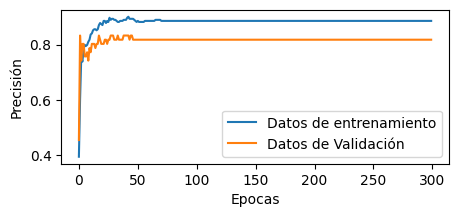

In [49]:
# Plot accuracy over epochs
plt.figure(figsize=(5,2))
plt.plot(history_distilledMLP.history['sparse_categorical_accuracy'], label='Datos de entrenamiento')
plt.plot(history_distilledMLP.history['val_sparse_categorical_accuracy'], label='Datos de Validación')
plt.xlabel('Epocas')
plt.ylabel('Precisión')
plt.legend()
#plt.title('Accuracy over epochs')
plt.show()

### RESULTADOS - MÉTRICAS CON DATOS DE TEST

3/3 [==============================] - 0s 8ms/step


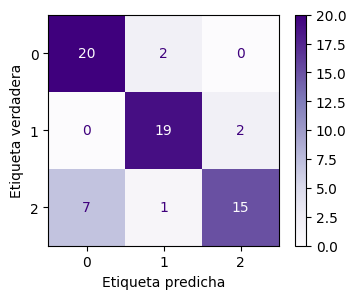

Precisión sobre el conjunto de test: 81.82%
Tasa de error: 18.18%


In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt  # Acordate de importar matplotlib si no estaba

# Obtener las predicciones
y_pred_probs = distilledMLP.student.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convertir y_test si está en one-hot
y_true = y_test  # Si estuviera en one-hot: y_true = np.argmax(y_test, axis=1)

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear figura
fig, ax = plt.subplots(figsize=(4,3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Purples', values_format='d')  # Mostrar como enteros

# Etiquetas en castellano
ax.set_xlabel('Etiqueta predicha')
ax.set_ylabel('Etiqueta verdadera')
#ax.set_title('Matriz de confusión')
plt.show()

# Calcular y mostrar accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Precisión sobre el conjunto de test: {accuracy*100:.2f}%")

# Calcular y mostrar error
error = 1 - accuracy
print(f"Tasa de error: {error*100:.2f}%")


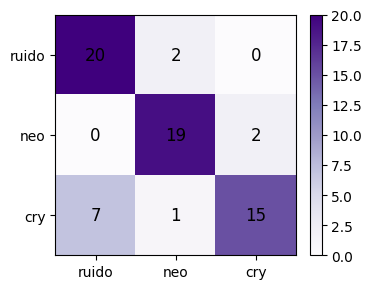

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que ya tenés:
# cm = matriz de confusión
class_names = ['ruido', 'neo', 'cry']

fig, ax = plt.subplots(figsize=(4,3))

# Dibujar la matriz
cax = ax.imshow(cm, cmap='Purples')


# Etiquetas de ejes

# Ticks en los ejes
# Ticks y nombres de clases
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)


# Etiquetas en cada casilla
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='black', fontsize=12)

# Barra de color ajustada
cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


### Guardar el modelo

In [20]:
distilledMLP.student.save('student_cangrejos.h5')
# Guardar solo los pesos
distilledMLP.student.save_weights('pesos_qkeras.h5')

## PROCESO DE IMPLEMENTACIÓN 

Durante el entrenamiento con QKeras, el modelo simula el comportamiento de una red cuantizada (por ejemplo, con pesos y activaciones tipo int8), aunque internamente los valores se representan en punto flotante (float32). Esto se hace porque el entrenamiento en punto flotante es más estable y permite una mejor optimización. Como resultado, se obtiene un modelo cuyos pesos son float32, pero que aprendió bajo las restricciones de precisión que impondría una implementación real con valores cuantizados.

Sin embargo, esta simulación no implica una cuantización real. Para llevar el modelo a una representación verdaderamente cuantizada, compatible con dispositivos embebidos, es necesario convertirlo utilizando TensorFlow Lite (TFLite). Como TFLite no es compatible con modelos QKeras, se construyó un modelo equivalente en Keras convencional, al que se le transfirieron los pesos obtenidos con QKeras. De este modo, fue posible aprovechar el entrenamiento consciente de la cuantización, y luego aplicar una cuantización entera (int8) real mediante TFLite para su implementación final en hardware.

### TRANFORMACIÓN A MODELO .TFLITE

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import load_model
from keras.utils import get_custom_objects

# Registrar las capas personalizadas de QKeras
get_custom_objects().update({
    'QDense': QDense,
    'QActivation': QActivation,
    'quantized_bits': quantizers.quantized_bits,  # Registrar el cuantizador 'quantized_bits'
})

# Paso 1: Crear la misma arquitectura en Keras tradicional
def build_keras_model():
    model = Sequential([
        Input(shape=(22,)),
        Dense(32, kernel_initializer='lecun_uniform', name='fc1'),
        Activation('relu', name='relu1'),
        
        Dense(16, kernel_initializer='lecun_uniform', name='fc2'),
        Activation('relu', name='relu2'),
        
        Dense(8, kernel_initializer='lecun_uniform', name='fc3'),
        Activation('relu', name='relu3'),
        
        Dense(3, kernel_initializer='lecun_uniform', name='output'),
        Activation('softmax', name='softmax')
    ])
    return model

# Paso 3: Construir el modelo Keras (sin cuantización)
model_keras = build_keras_model()

# Paso 4: Transferir los pesos de QKeras a Keras
# Aquí simplemente tomamos los pesos del modelo cuantizado y los cargamos en el nuevo modelo Keras
# Cargar los pesos en el nuevo modelo
model_keras.load_weights('pesos_qkeras.h5')

# Verificación
model_keras.summary()

# Guardar el modelo de Keras con los pesos ya transferidos
model_keras.save('modelo_keras_con_pesos.h5')


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 32)                736       
                                                                 
 relu1 (Activation)          (None, 32)                0         
                                                                 
 fc2 (Dense)                 (None, 16)                528       
                                                                 
 relu2 (Activation)          (None, 16)                0         
                                                                 
 fc3 (Dense)                 (None, 8)                 136       
                                                                 
 relu3 (Activation)          (None, 8)                 0         
                                                                 
 output (Dense)              (None, 3)                

In [54]:
import tensorflow as tf
import numpy as np

# Cargar el modelo
model = tf.keras.models.load_model('modelo_keras_con_pesos.h5')

# Asegurarse que los datos de entrada son float32
X_train = X_train.astype(np.float32)

# Dataset representativo. Y usa el representative_dataset para hacer bien el mapeo,
#es decir, para elegir los valores de scale y zero_point en cada capa.
def representative_data_gen():
    for i in range(100):
        yield [X_train[i:i+1]]

# Conversión a TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Forzar cuantización entera
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convertir y guardar
tflite_model = converter.convert()

with open('modelo_converted_quantized.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\CELESTE\AppData\Local\Temp\tmp2vjyoscj\assets


INFO:tensorflow:Assets written to: C:\Users\CELESTE\AppData\Local\Temp\tmp2vjyoscj\assets
c:\Users\CELESTE\anaconda3\envs\tinyml\lib\site-packages\tensorflow\lite\python\convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


### INFERENCIA DEL MODELO
La inferencia con el modelo cuantizado fue validada en un entorno de escritorio utilizando la API de TensorFlow Lite para Python. Esta simulación permite verificar el comportamiento del modelo int8 antes de su implementación final en el ESP32.

In [638]:
interpreter = tf.lite.Interpreter(model_path="modelo_converted_quantized.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)


Input details: [{'name': 'serving_default_input_46:0', 'index': 0, 'shape': array([ 1, 22]), 'shape_signature': array([-1, 22]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 11, 'shape': array([1, 3]), 'shape_signature': array([-1,  3]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


### USO DE RECURSOS

In [ ]:
import os

details = interpreter.get_tensor_details()

total_tensor_memory = 0
for tensor in details:
    shape = tensor['shape_signature'] if 'shape_signature' in tensor else tensor['shape']
    dtype_size = np.dtype(tensor['dtype']).itemsize
    num_elements = np.prod(shape)
    total_tensor_memory += dtype_size * num_elements
print(f"Memoria total de tensores en RAM: {total_tensor_memory / 1024:.2f} KB")

tamaño_modelo = os.path.getsize('modelo_converted_quantized.tflite')  # en bytes
print(f"Tamaño del modelo: {tamaño_modelo/1024:.2f} KB")


Memoria total de tensores en RAM: 1.41 KB


### ENTRADA REAL DESDE EL ADC
Se simula una entrada de 8 bit proveniente del ADC

In [641]:
# Seleccionar una entrada real del conjunto de entrenamiento X_test
# Asegúrate de que la entrada tenga la forma correcta (1, 22)
real_input = np.expand_dims(X_test[8], axis=0)  # Convierte (22,) a (1, 22)
# Selecciona la primera muestra de X_train
print(real_input)

[[0.98431373 0.90196078 0.0745098  0.21176471 0.65490196 0.06666667
  0.74509804 0.1254902  0.01960784 0.14901961 0.21176471 0.21568627
  0.92156863 0.55686275 0.51372549 0.94509804 0.39215686 0.25882353
  0.35294118 0.24313725 0.16470588 0.31372549]]


In [642]:
# Obtener los parámetros de cuantización de la entrada
input_scale, input_zero_point = input_details[0]['quantization']

# Cuantizar la entrada real (si el modelo es cuantizado)
quantized_input_data = np.round(real_input / input_scale + input_zero_point).astype(np.int8)

print(quantized_input_data, input_scale, input_zero_point )


[[ 123  102 -109  -74   39 -111   62  -96 -123  -90  -74  -73  107   14
     3  113  -28  -62  -38  -66  -86  -48]] 0.003921568859368563 -128


In [643]:
# Asignar la entrada al tensor del modelo
interpreter.set_tensor(input_details[0]['index'], quantized_input_data)
# Realizar la inferencia
interpreter.invoke()
# Obtener la salida del modelo
output_data = interpreter.get_tensor(output_details[0]['index'])

# Si la salida está cuantizada, hacer la descuantización
output_scale, output_zero_point = output_details[0]['quantization']

# ⚡ Correcto: casteo primero
output_float = (output_data.astype(np.float32) - output_zero_point) * output_scale

# Imprimir la salida
print("Output data (cuantizada):", output_data)
print("Output data (descuantizada):", output_float)


Output data (cuantizada): [[-15 -70 -43]]
Output data (descuantizada): [[0.44140625 0.2265625  0.33203125]]


### RESULTADOS DE LA INFERENCIA DE LA IMPLEMENTACIÓN

In [644]:
# Mostrar etiqueta verdadera y predicha
etiqueta_real = y_test[8]  # El índice de la muestra que estés usando
etiqueta_predicha = np.argmax(output_float)

print(f"Etiqueta real: {etiqueta_real}")
print(f"Etiqueta predicha: {etiqueta_predicha}")

if etiqueta_real == etiqueta_predicha:
    print("✅ ¡Clasificación correcta!")
else:
    print("❌ Clasificación incorrecta.")


Etiqueta real: 2
Etiqueta predicha: 0
❌ Clasificación incorrecta.


In [645]:
print(y_test[8])

2


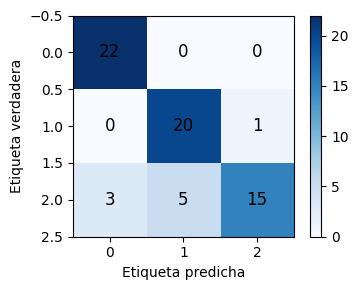


Accuracy: 0.8636


In [648]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Nombres de las clases
class_names = ['Ruido', 'Cry', 'Neo']

# Calcular matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred)

# Mostrar matriz de confusión usando los nombres
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)

import matplotlib.pyplot as plt
import numpy as np

# Supongamos que ya tenés tu matriz conf_mat
# conf_mat = np.array(...) 

# Crear figura
fig, ax = plt.subplots(figsize=(4,3))
im = ax.imshow(conf_mat, cmap='Blues')

# Etiquetas
ax.set_xlabel('Etiqueta predicha')
ax.set_ylabel('Etiqueta verdadera')

# Mostrar los números dentro de las celdas
num_classes = conf_mat.shape[0]
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, conf_mat[i, j],
                ha='center', va='center',
                color='black', fontsize=12)

# Agregar barra de colores
fig.colorbar(im, ax=ax)

# Mostrar
plt.tight_layout()
plt.show()


# Mostrar el accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")


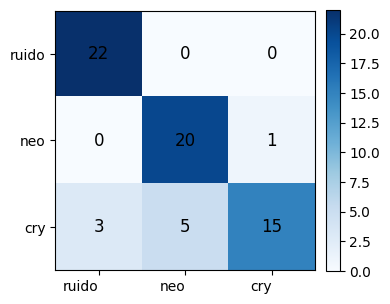


Accuracy: 0.8636


In [650]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supongamos que ya tenés:
# conf_mat = matriz de confusión
# y_true = etiquetas verdaderas
# y_pred = etiquetas predichas

class_names = ['ruido', 'neo', 'cry']

fig, ax = plt.subplots(figsize=(4,4))

# Dibujar la matriz
im = ax.imshow(conf_mat, cmap='Blues')

# Ticks y nombres de clases
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotar etiquetas del eje x para que no se superpongan
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

# Mostrar los números dentro de las celdas
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(j, i, format(conf_mat[i, j], 'd'),
                ha='center', va='center',
                color='black', fontsize=12)

# Agregar barra de colores
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Ajuste layout
plt.tight_layout()
plt.show()

# Mostrar el accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
